In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('notebooks_final/DATA/gene_expression.csv')
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


3000

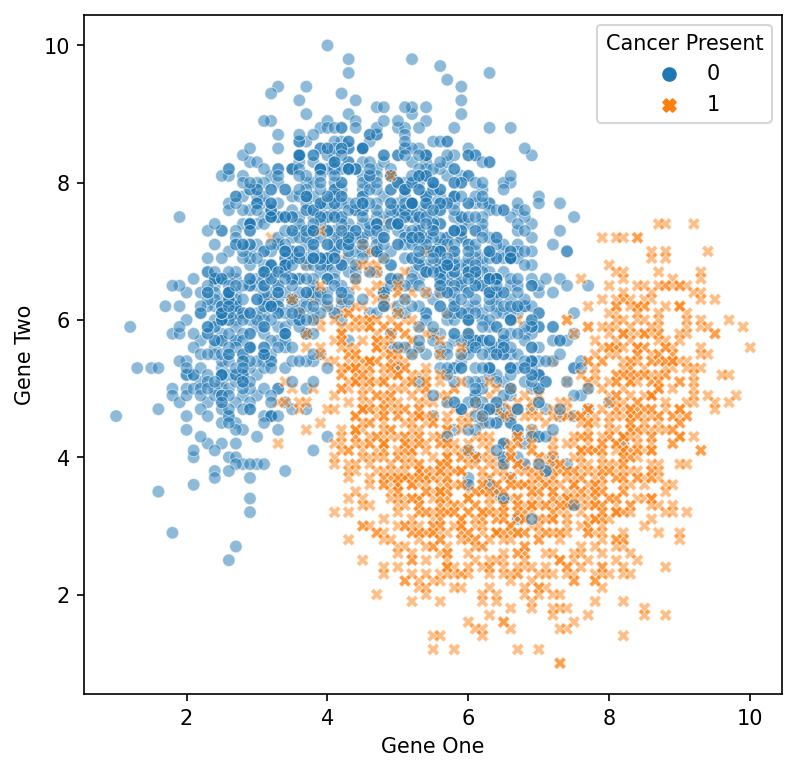

In [15]:
plt.figure(figsize=(6,6), dpi=150)
sns.scatterplot(x='Gene One', y='Gene Two', data=df, hue='Cancer Present', alpha=0.5, style='Cancer Present')
len(df)

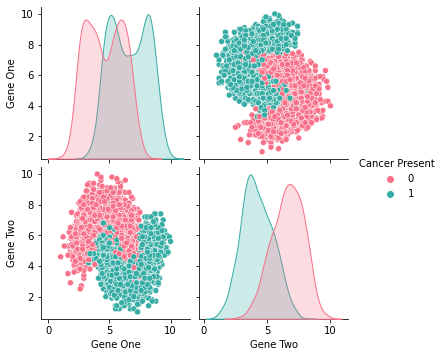

In [16]:
sns.pairplot(df, hue='Cancer Present', palette='husl')

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('Cancer Present', axis=1)
y = df['Cancer Present']

X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
scaled_X_Train = scaler.fit_transform(X_Train)
scaled_X_Test = scaler.transform(X_Test)

In [23]:
from sklearn.neighbors import KNeighborsClassifier
#help(KNeighborsClassifier)
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(scaled_X_Train, y_Train)

KNeighborsClassifier(n_neighbors=1)

In [24]:
y_pred = knn_model.predict(scaled_X_Test)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

confusion_matrix(y_Test, y_pred)

array([[420,  50],
       [ 47, 383]])

In [28]:
print(classification_report(y_Test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       470
           1       0.88      0.89      0.89       430

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



In [31]:
df['Cancer Present'].value_counts() # Perfect balanced dataset

1    1500
0    1500
Name: Cancer Present, dtype: int64

# Let's find a better K

In [33]:
from sklearn.metrics import accuracy_score
error = 1 - accuracy_score(y_Test, y_pred)
error

0.10777777777777775

Text(0, 0.5, 'Error Rate')

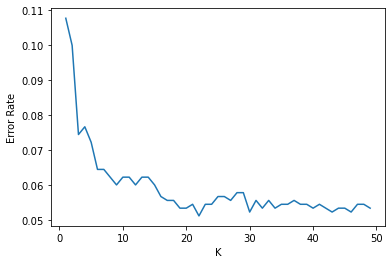

In [35]:
test_error_rates = []
for k in range(1, 50):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_Train, y_Train)
    y_pred_test = knn_model.predict(scaled_X_Test)
    test_error = 1 - accuracy_score(y_Test, y_pred_test)
    test_error_rates.append(test_error)

# test_error_rates
plt.plot(range(1, 50), test_error_rates)
plt.xlabel('K')
plt.ylabel('Error Rate')

In [37]:
# pipeline -> GridSearchCV
scaler = StandardScaler()
knn = KNeighborsClassifier()
knn.get_params().keys()


dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [38]:
operations = [('scaler', scaler), ('knn', knn)]

from sklearn.pipeline import Pipeline
pipe = Pipeline(operations)

---
*Note: If your parameter grid is going inside a PipeLine, your parameter name needs to be specified in the following manner:**

* chosen_string_name + **two** underscores + parameter key name
* model_name + __ + parameter name
* knn_model + __ + n_neighbors
* knn_model__n_neighbors

[StackOverflow on this](https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline)

The reason we have to do this is because it let's scikit-learn know what operation in the pipeline these parameters are related to (otherwise it might think n_neighbors was a parameter in the scaler).

---

In [40]:
from sklearn.model_selection import GridSearchCV
k_values = list(range(1, 20))
param_grid = {'knn__n_neighbors': k_values}

In [41]:
full_cv_classifier = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

In [42]:
full_cv_classifier.fit(X_Train, y_Train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [44]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=14))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=14),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 14,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [46]:
full_pred = full_cv_classifier.predict(X_Test)

In [48]:
print(classification_report(y_Test, full_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       470
           1       0.95      0.92      0.93       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



In [50]:
new_patient = [[3.8, 6.4]]
full_cv_classifier.predict(new_patient)

array([0])

In [51]:
full_cv_classifier.predict_proba(new_patient)

array([[1., 0.]])